In [ ]:
%load_ext watermark
%watermark -v -n -m -p numpy,openslide,cv2,pandas

In [9]:
import numpy as np
import pandas as pd
from openslide import OpenSlide
from openslide.deepzoom import DeepZoomGenerator
import os
import matplotlib
import matplotlib.pyplot as plt
import PIL
import cv2
import math
from collections import Counter
from pathlib import Path
from concurrent.futures import ThreadPoolExecutor, as_completed

import isupgrading.tiler

ModuleNotFoundError: No module named 'isupgrading'

In [2]:
# Location of the training images
data_dir = "/data/raw/small_panda_dataset/train_images"
mask_dir = "/data/raw/small_panda_dataset/train_label_masks"

# Location of training labels
train_labels = pd.read_csv("/data/raw/small_panda_dataset/train.csv").set_index("image_id")

train_labels.tail(30)

,data_provider,isup_grade,gleason_score
image_id,,,
ff4cd20d67101688ada57fbabe318e3a,karolinska,1,3+3
ff5130c98c14c90ae7f4dd64c297070c,karolinska,0,0+0
ff53524d64cae1675216bbda40ad7cac,radboud,4,4+4
ff567263913a91c99abbe39d9d679b93,karolinska,0,0+0
ff596d5292ab979e9ba7291d0743b3fb,karolinska,0,0+0
ff602bd9652640d4b534d7a78fc64b6a,karolinska,0,0+0
ff6e67a5f0b674097f5142ec24eb8fcb,karolinska,0,0+0
ff79f700dc97b2fd05d92e56f4b4a815,karolinska,0,0+0
ff80dfefc41b8863b476c5840f88fec0,radboud,5,5+4


In [3]:
print(f"Total count before filtering: {len(train_labels.index)}")
# Drop falsely labeled image
train_labels.drop(["b0a92a74cb53899311acc30b7405e101"], inplace=True)

# Change negative gleason_score to 0+0
train_labels["gleason_score"] = train_labels["gleason_score"].apply(lambda x: "0+0" if x=="negative" else x)

train_labels = train_labels[train_labels["gleason_score"].isin(["0+0","3+3","4+4","5+5"])]
print(f"Total count after filtering: {len(train_labels.index)}")

Total count before filtering: 10616
Total count after filtering: 6811


In [4]:
table1 = train_labels.groupby(["data_provider", "gleason_score", "isup_grade"]).size().reset_index(name="counts")
table1.style.background_gradient(cmap="Purples", vmin=5)

,data_provider,gleason_score,isup_grade,counts
0,karolinska,0+0,0,1925
1,karolinska,3+3,1,1814
2,karolinska,4+4,4,466
3,karolinska,5+5,5,16
4,radboud,0+0,0,967
5,radboud,3+3,1,852
6,radboud,4+4,4,660
7,radboud,5+5,5,111


In [5]:
train_labels.sample(20)

,data_provider,isup_grade,gleason_score
image_id,,,
915dd7918f5bbd16aa1ec7a677dcfe13,radboud,1,3+3
79e6f48335f8260876bff6941eddbf18,karolinska,0,0+0
e4368e6ebbcd17b0fef1f385f33fd5e0,radboud,1,3+3
fd9c0a935d2f7830682924b79130c0ba,karolinska,0,0+0
0f955260121c6c2f54e1301e8c738153,karolinska,0,0+0
6f56c1a8d9755e36fc3329797d59874a,karolinska,0,0+0
ce24af9d3fb0d05a754acfcc0ec1a700,karolinska,0,0+0
d065d62d5db3a99245b8eff06975c94f,karolinska,1,3+3
c6b4ba956e1d4fbe744d6e2839b4a723,radboud,1,3+3


In [6]:
def add_mask_to_plot(plt, mask_data, provider):  
    vmin=0
    vmax=5
    cmap=None
    
    if provider == "radboud":
        cmap = matplotlib.colors.ListedColormap(["white", "gray", "green", "yellow", "orange", "red"])
        vmax=5
    else:
        cmap = matplotlib.colors.ListedColormap(["white", "green", "red"])
        vmax=2
        
    plt.imshow(np.asarray(mask_data)[:,:,0], interpolation="nearest", cmap=cmap, vmin=0, vmax=vmax)


def plot_mask(mask_data, provider):
    plt.figure(figsize=(8,8))
    add_mask_to_plot(plt, mask_data, provider)
    plt.axis("off")
    plt.show()

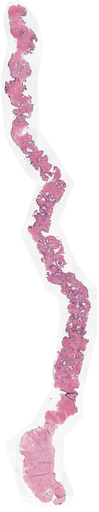

In [7]:
img_id = "66c3f1134c199363086f278ec30c3e7a"
biopsy = OpenSlide(os.path.join(data_dir, f"{img_id}.tiff"))
biopsy_mask = OpenSlide(os.path.join(mask_dir, f"{img_id}_mask.tiff"))

biopsy.get_thumbnail((512,512))

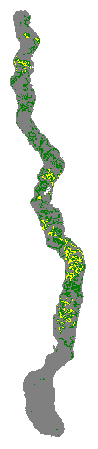

In [8]:
mask_data = biopsy_mask.get_thumbnail((512,512))
plot_mask(mask_data, train_labels.loc[img_id].data_provider)

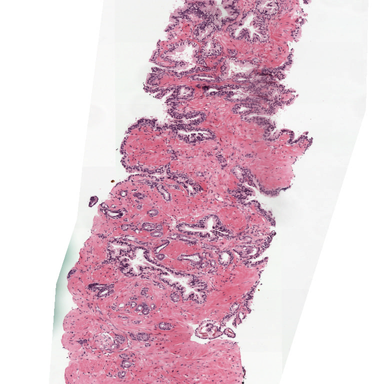

In [9]:
tile_size=384
overlap=64
level=12

biopsy_tiler = DeepZoomGenerator(biopsy, tile_size=tile_size, overlap=overlap)
biopsy_mask_tiler = DeepZoomGenerator(biopsy_mask, tile_size=tile_size, overlap=overlap)

region=(1,6)

biopsy_tiler.get_tile(level, region).resize((384,384))

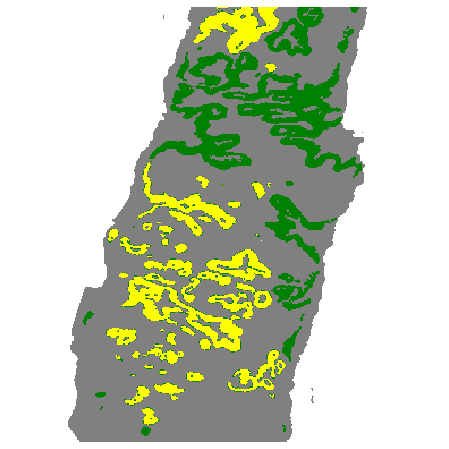

In [10]:
biopsy_mask_tile_data = biopsy_mask_tiler.get_tile(level, region).resize((384,384))
plot_mask(biopsy_mask_tile_data, train_labels.loc[img_id].data_provider)

In [11]:
def pad_tile(img, tile_size, mask, row, column):
    x, y = img.size
    img = np.asarray(img)
    
    colour = (255,255,255)
    if mask:
        colour = (0,0,0)
    
    if x < tile_size:
        if column == 0:
            img = cv2.copyMakeBorder(img, 0, 0, tile_size-x, 0, cv2.BORDER_CONSTANT, value=colour)
        else:
            img = cv2.copyMakeBorder(img, 0, 0, 0, tile_size-x, cv2.BORDER_CONSTANT, value=colour)
            
    if y < tile_size:
        if row == 0:
            img = cv2.copyMakeBorder(img, tile_size-y, 0, 0, 0, cv2.BORDER_CONSTANT, value=colour)
        else:
            img = cv2.copyMakeBorder(img, 0, tile_size-y, 0, 0, cv2.BORDER_CONSTANT, value=colour)
        
    return img

def get_most_gleason_pixels(gleason_count):
    for i, count in enumerate(gleason_count):
        if count[0] > 2:
            return i
    
    return None

def get_amount_of_beningn_pixels(gleason_count, provider):
    benign_threshold = 1
    
    if provider == radboud:
        benign_threshold = 2
        
    pixels = 0
    
    for i, count in enumerate(gleason_count):
        if count[0] <= benign_threshold:
            pixels += count[1]
    
    return pixels

def get_tiles_for_slide(img_id, area_threshold=0.1, gleason_area_threshold=0.05, benign_area_threshold=0.05,
                        benign_to_gleason_threshold=0.1, tile_size=512, overlap=64, level=12, figsize=(0, 0), draw=False):    
    provider = train_labels.loc[img_id].data_provider
    
    biopsy = DeepZoomGenerator(OpenSlide(os.path.join(data_dir, f"{img_id}.tiff")), tile_size=tile_size-overlap*2, overlap=overlap)
    biopsy_mask = DeepZoomGenerator(OpenSlide(os.path.join(mask_dir, f"{img_id}_mask.tiff")), tile_size=tile_size-overlap*2, overlap=overlap)

    nrows = biopsy.level_tiles[level][1]
    ncols = biopsy.level_tiles[level][0]
    
    fig, axs = (None,None)
    fig_mask, axs_mask = (None,None)
    ret = []
    
    if draw:
        if figsize==(0,0):
            figsize=(ncols*2,nrows*2)
        fig, axs = plt.subplots(nrows, ncols, figsize=figsize)
        fig_mask, axs_mask = plt.subplots(nrows, ncols, figsize=figsize)
    
    for row in range(nrows):
        for column in range(ncols):
            img = biopsy.get_tile(level, (column, row))
            mask = biopsy_mask.get_tile(level, (column, row))
            gleason_score = 0
            
            gleason_pixels = np.asarray(mask)[:,:,0].flatten()
            gleason_pixels = gleason_pixels[gleason_pixels != 0]
            gleason_count = Counter(gleason_pixels).most_common()
            gleason_pixels = 0
            benign_pixels = 0
            
            if provider == "radboud":
                if len(gleason_count) > 0:
                    index = get_most_gleason_pixels(gleason_count)
                    if index is not None:
                        gleason_score = gleason_count[index][0]
                
                if gleason_score == 2 or gleason_score == 1:
                    gleason_score = 0
                    
                for count in gleason_count:
                    if count[0] <= 2:
                        benign_pixels += count[1]
                    else:
                        gleason_pixels += count[1]
            else:                
                for count in gleason_count:
                    if count[0] == 1:
                        benign_pixels = count[1]
                    if count[0] == 2:
                        gleason_pixels = count[1]
                        
                if benign_pixels == 0:
                    gleason_score = int(train_labels.loc[img_id].gleason_score.split("+")[0])
                elif gleason_pixels/benign_pixels > 0.2:
                    gleason_score = int(train_labels.loc[img_id].gleason_score.split("+")[0])
                    
                        
                    
        
            # Pad edges
            img = pad_tile(img, tile_size, False, row, column)
            mask = pad_tile(mask, tile_size, True, row, column)
            
            imgray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            thresh = cv2.threshold(imgray, 230, 255, cv2.THRESH_BINARY_INV)[1]
            cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            
            cnts = cnts[0] if len(cnts) == 2 else cnts[1]
            
            display_img = np.copy(img)
            display_mask_img = np.copy(mask)
                        
            area = 0
            if len(cnts) > 0:
                cv2.drawContours(display_img, cnts, -1, color=(0, 255, 0), thickness=4, lineType=cv2.LINE_AA)
                for cnt in cnts:
                    area += cv2.contourArea(cnt)
            
            if ((area/(tile_size**2) < area_threshold) or 
                (gleason_score > 0 and gleason_pixels/area<gleason_area_threshold) or 
                (gleason_score == 0 and benign_pixels/area<benign_area_threshold) or
                (gleason_score == 0 and gleason_pixels > 0 and benign_pixels/gleason_pixels < benign_to_gleason_threshold)):
                
                close = int(tile_size/3)
                far = int(tile_size*2/3)
                
                display_img = cv2.add(display_img, np.array([-75.0]))
                cv2.line(display_img,(close,close),(far,far),(255,0,0),5)
                cv2.line(display_img,(close,far),(far,close),(255,0,0),5)
                
                cv2.line(display_mask_img,(close,close),(far,far),(255,0,0),5)
                cv2.line(display_mask_img,(close,far),(far,close),(255,0,0),5)
            else:
                ret.append([img, mask, gleason_score])
                
            if draw:
                axs[row,column].imshow(display_img, aspect="auto")
                axs[row,column].tick_params(which="both",bottom=False,left=False,labelbottom=False,labelleft=False)
                
                add_mask_to_plot(axs_mask[row,column], display_mask_img, provider)
                axs_mask[row,column].set_aspect("auto")
                axs_mask[row,column].tick_params(which="both",bottom=False,left=False,labelbottom=False,labelleft=False)
    
    if draw:
        fig.subplots_adjust(hspace = 0, wspace= 0)
        fig.show()
        
        fig_mask.subplots_adjust(hspace = 0, wspace= 0)
        fig_mask.show()
        
    return ret

In [12]:
def plot_tiles(tiles, provider="", mask=False):
    grid_size = math.ceil(len(tiles)**0.5)

    fig, axs = plt.subplots(grid_size, grid_size, figsize=(16,16))
    axs = axs.flatten()

    for ax in axs:
        ax.axis("off")

    for tile, ax in zip(tiles, axs):
        ax.axis("on")
        ax.tick_params(which="both",bottom=False,left=False,labelbottom=False,labelleft=False)
        ax.title.set_text(f"GS: {tile[2]}")
        if mask:
            add_mask_to_plot(ax, tile[1], provider)
        else:
            ax.imshow(tile[0])
    
    fig.tight_layout()
    plt.show()

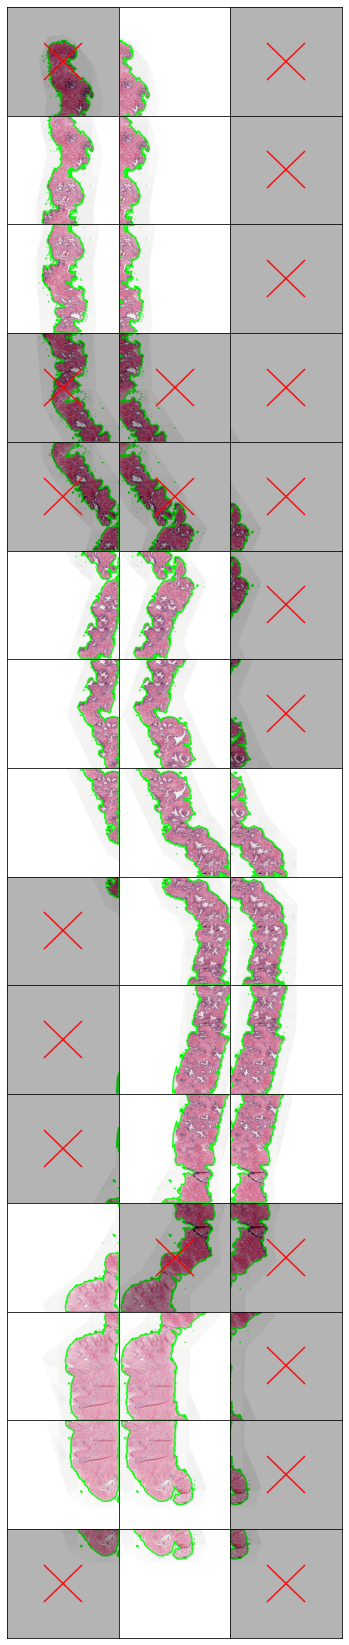

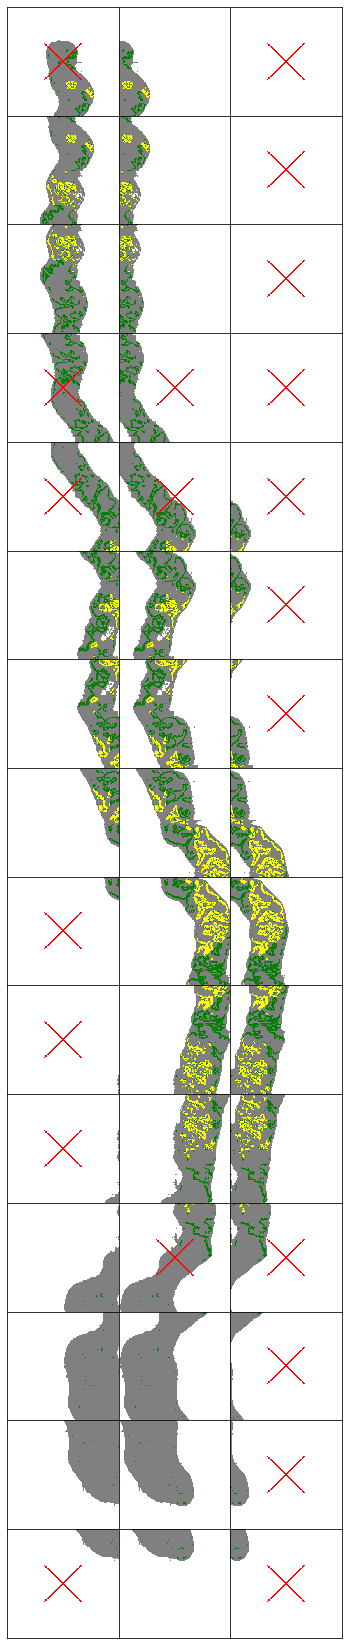

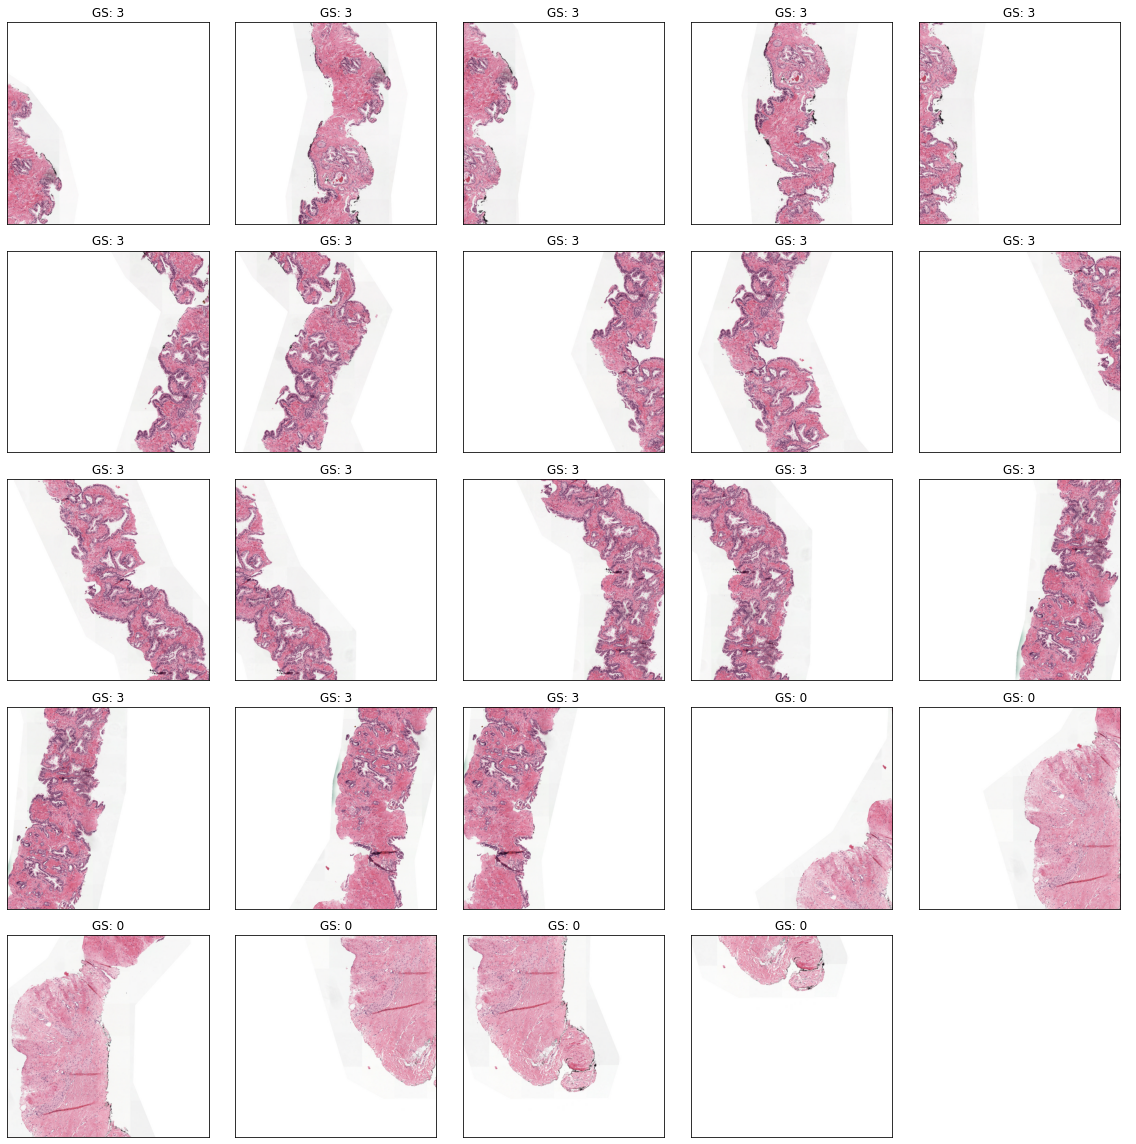

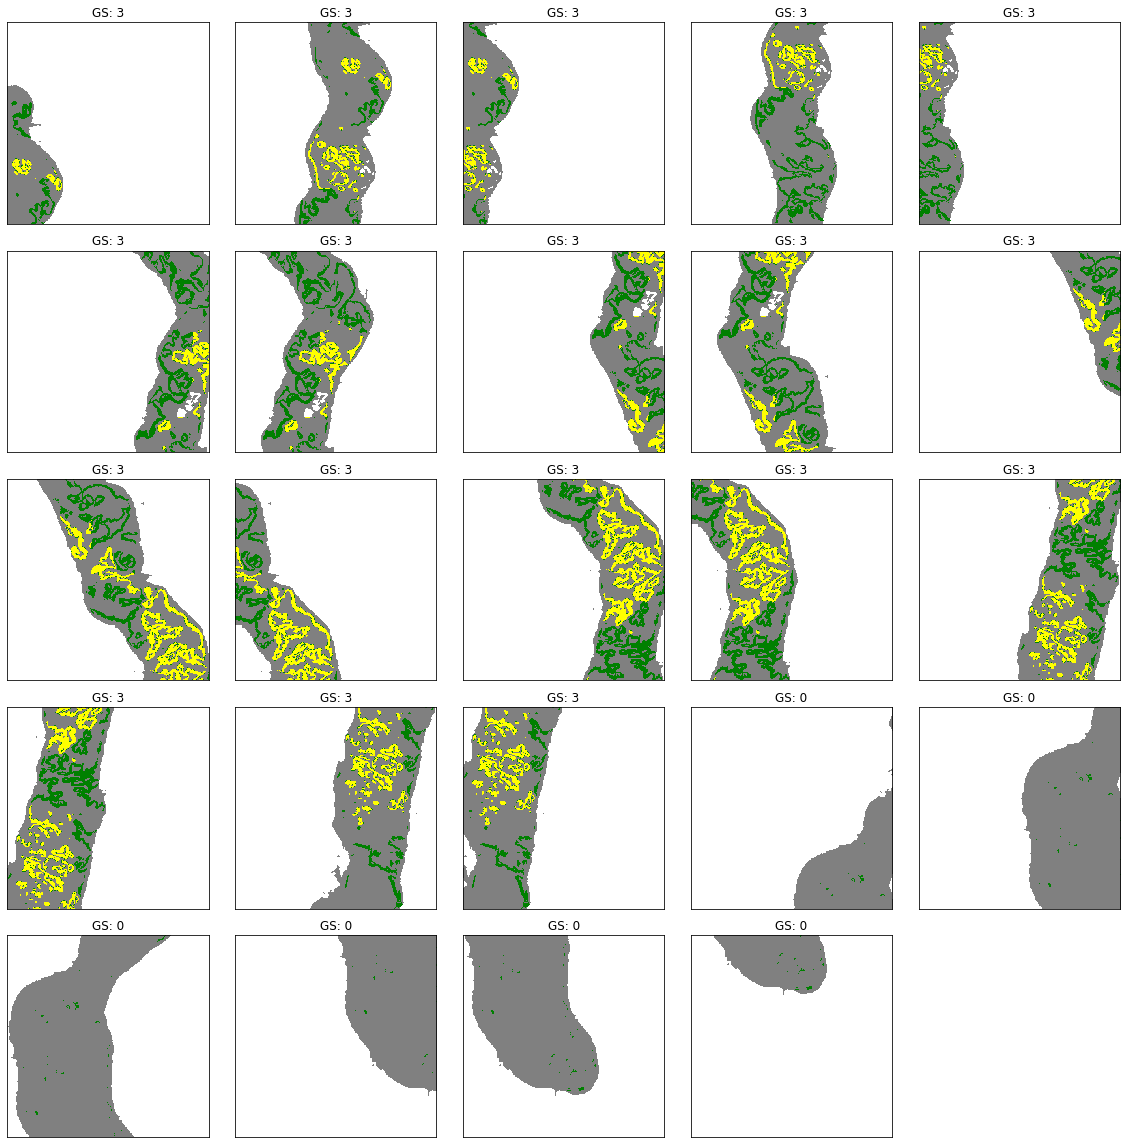

In [13]:
tiles = get_tiles_for_slide(img_id, overlap=128, draw=True)
plot_tiles(tiles)
plot_tiles(tiles, train_labels.loc[img_id].data_provider, mask=True)

In [14]:
def save_tiles(img_id):
    tile_gleason = []
    tiles = get_tiles_for_slide(img_id, overlap=128, draw=False)
    for i, tile in enumerate(tiles):
        tile_img, _, gleason = tile
        file_name = f"{img_id}_{i}"
        tile_gleason.append({"tile_id":file_name, "gleason": gleason})
        cv2.imwrite(os.path.join("./tiles", f"{file_name}.png"), tile_img)
    
    return tile_gleason

In [15]:
Path("./tiles").mkdir(parents=True, exist_ok=True)

tile_id_gleason = []
img_ids = train_labels.index.values.tolist()[:3000]

processes = []
with ThreadPoolExecutor() as executor:
    for img_id in img_ids:
        processes.append(executor.submit(save_tiles, img_id))

for task in as_completed(processes):
    tile_id_gleason = tile_id_gleason + task.result()

df = pd.DataFrame(tile_id_gleason)
df.set_index("tile_id")
df.to_csv("train.csv", index=False)

OpenSlideUnsupportedFormatError: Unsupported or missing image file